<a href="https://colab.research.google.com/github/markbriers/data-science-jupyter/blob/main/week8_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Modelling part 3 (Week 8)

Code at: https://github.com/markbriers/data-science-jupyter

## Recap - the story so far

Our goal is to follow a data science process (CRISP-DM) to deliver a successful business outcome.

Our learning objectives are as follows:

* Describe the six stages of a data processing pipeline (using CRISP-DM)

* Demonstrate an understanding of the python programming language through the production of elementary data analysis programme

* Analyse at least three different data sources by applying at least one python data processing library to extract and explore pertinent features

* Be able to design a set of data requirements for a specified business problem

* Describe and apply (using the python programming language) the main approaches to supervised learning for a given classification problem

* Understand the use cases of Big Data technology (in particular Spark)

* Produce a report including appropriate data visualisations covering the analysis of a business problem using a data science based approach

## Learning outcome

* By the end of the lecture, you will be able to use the tensorflow library to estimate parameters of a binary classification model.

* By the end of the lecture, you will be able to use the tensorflow library to estimate parameters of a deep neural network.

* By the end of the lecture, you will have a high level understanding of Generative Adversarial Networks (GANs), and how they can be used to generate "fake news".

# Bernoulli distribution and coin tossing

Let's compute the following probabilities:
* Tossing T with a fair coin
* Tossing HH with a fair coin
* Tossing HT with a fair coin
* Tossing HTH with a fair coin
* Tossing H with a biased coin ($p(head) = \lambda = 0.1$)
* Tossing HT with a biased coin ($p(head) = \lambda = 0.1$)

Now we'll (informally) introduce the concept of a random variable, denoted $C$, where $C=0$ corresponds to coin landing on heads and $C=1$ corresponds to coin landing on tails. The probability of $C=1$ is equal to $\lambda$. If $\lambda=0.5$ then the coin is unbiased (and we're maximally uncertain about the outcome of a coin toss.

We can say that $C$ follows a Bernoulli distribution, with *probability mass function* equal to the following expression:
\begin{equation}
p(C|\lambda) = \lambda^{C}(1-\lambda)^{1-C}
\end{equation}

## Logistic regression - binary classification (supervised learning)

Consider the scenario where we wish to partition objects into two categories (e.g. spam or not spam, fraud or not fraud, positive sentiment or negative sentiment, face present or face not present, ...) given a set of attributes. The simplest (and widest used) model to achieve this is known as a Logistic Regression model. The Logistic Regression model "squashes" the output of a linear regression model, so that the resultant squashed output is between $0$ and $1$. This "squashed" output can be interpreted as a class probabaility (e.g. probability of spam or not spam). So what is the squashing function?

### Sigmoid function

$sigm(\eta)$ is known as the sigmoid function (also known as the _logistic_ or _logit_ function):

\begin{equation}
sigm(\eta) = \frac{1}{1+e^{-\eta}} = \frac{e^{\eta}}{e^{\eta}+1}
\end{equation}

This function has the property that is "squashes" any input (from $-\infty < \eta < \infty$) to a value between 0 and 1.

We can use the Bernouilli expression introduced above to model input data and (probabilistically) ascertain whether the data are from one class or another:

\begin{equation}
\prod_{i=1}^{N} Ber(C_{i}|sigm(\theta x_{i})) = \prod_{i=1}^{N} \left[\frac{1}{1+e^{-\theta x_{i}}} \right]^{C_{i}} \left[1-\frac{1}{1+e^{-\theta x_{i}}} \right]^{1-C_{i}}
\end{equation}

So how do we estimate model parameters $\theta$? What is the loss function?

### Cross-entropy loss

Let's introduce entropy: https://en.wikipedia.org/wiki/Entropy_(information_theory). Entropy can be considered to be a measure of uncertainty. For example, in the case of coin tossing, the value oof $\lambda$ that maximises entropy is $\lambda = 0.5$ - we are maximally uncertain about the outcome of the "experiment". We therefore want to chose a value of $\theta$ (in the above model) that minimises *cross entropy loss*:
\begin{equation}
c(\theta) = -\frac{1}{N}\sum_{i=1}^{N} \left[C_{i}log\hat{C}_{i}+(1-C_{i})log(1-\hat{C}_{i})\right]
\end{equation}

where:
\begin{equation}
\hat{C}_{i} = \frac{1}{1+e^{-\theta x_{i}}}
\end{equation}

In order to compute the optimal value of $\theta$ that minimises the cross entropy loss, we use the chain rule (differentiation of composed functions) and gradient descent.

### Tensorflow implementation


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow version: 2.15.0


The dataset basically consists of 7 columns:

* price (the buying price of the car)
* maint (the maintenance cost)
* doors (number of doors)
* persons (the seating capacity)
* lug_capacity (the luggage capacity)
* safety (how safe is the car)
* output (the condition of the car)

Given the first 6 columns, the task is to predict the value for the 7th column i.e. the output column.

In [2]:
cols = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety','output']
cars = pd.read_csv('https://raw.githubusercontent.com/vortexeye/Car-Evaluation/master/car_evaluation.csv', names=cols, header=None)
cars.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


### Brief exploratory analysis

Let's perform a brief exploratory analysis of the data:

<Axes: ylabel='output'>

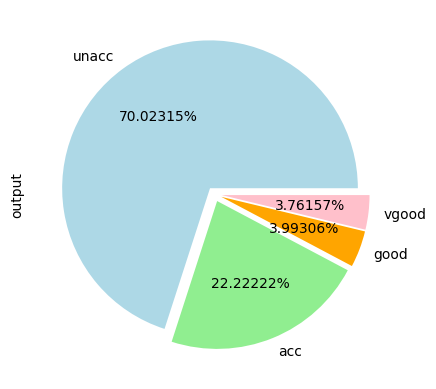

In [3]:
cars.output.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05,0.05))

Let's convert the categorical values into numerical values (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies):

In [4]:
price = pd.get_dummies(cars.price, prefix='price') #The get_dummies() function is used to convert categorical variable into dummy/indicator variables
maint = pd.get_dummies(cars.maint, prefix='maint')

doors = pd.get_dummies(cars.doors, prefix='doors')
persons = pd.get_dummies(cars.persons, prefix='persons')

lug_capacity = pd.get_dummies(cars.lug_capacity, prefix='lug_capacity')
safety = pd.get_dummies(cars.safety, prefix='safety')

labels = pd.get_dummies(cars.output, prefix='condition')

Now concatonate the two data frames (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html):

In [5]:
X = pd.concat([price, maint, doors, persons, lug_capacity, safety] , axis=1)
X.head()

,price_high,price_low,price_med,price_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_capacity_big,lug_capacity_med,lug_capacity_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


The labels dataframe corresponds to the output category (i.e. the condition of the vehicle):

In [6]:
labels.head()

,condition_acc,condition_good,condition_unacc,condition_vgood
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [7]:
y = labels.values

We'll randomly split the data into training and test data:

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

And create the model as layers in tensorflow:

In [9]:
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model

In [10]:
input_layer = Input(shape=(X.shape[1],))
output = Dense(y.shape[1], activation='softmax')(input_layer)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

The softmax activation function acts as a generalisation of the sigmoid function in logistic regression, to allow for multi-class classification problems (i.e. it extends binary classification) - see https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html

In [11]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 4)                 88        
                                                                 
Total params: 88 (352.00 Byte)
Trainable params: 88 (352.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Now we can fit the model (i.e. estimate the parameters):

In [12]:
history = model.fit(X_train, y_train, batch_size=8, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
139/139 [==============================] - 2s 7ms/step - loss: 1.2267 - acc: 0.4661 - val_loss: 0.9876 - val_acc: 0.6390
Epoch 2/50
139/139 [==============================] - 1s 6ms/step - loss: 0.8088 - acc: 0.7222 - val_loss: 0.8571 - val_acc: 0.6643
Epoch 3/50
139/139 [==============================] - 1s 4ms/step - loss: 0.7074 - acc: 0.7348 - val_loss: 0.7992 - val_acc: 0.6823
Epoch 4/50
139/139 [==============================] - 1s 6ms/step - loss: 0.6556 - acc: 0.7403 - val_loss: 0.7563 - val_acc: 0.6931
Epoch 5/50
139/139 [==============================] - 1s 4ms/step - loss: 0.6190 - acc: 0.7548 - val_loss: 0.7235 - val_acc: 0.6895
Epoch 6/50
139/139 [==============================] - 1s 5ms/step - loss: 0.5906 - acc: 0.7629 - val_loss: 0.6936 - val_acc: 0.6859
Epoch 7/50
139/139 [==============================] - 1s 5ms/step - loss: 0.5674 - acc: 0.7783 - val_loss: 0.6710 - val_acc: 0.7076
Epoch 8/50
139/139 [==============================] - 1s 8ms/step - loss: 0.

And evaluate how well the model has performed on the held-out test set:

In [13]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

11/11 [==============================] - 0s 2ms/step - loss: 0.3749 - acc: 0.8439
Test Score: 0.3748660087585449
Test Accuracy: 0.8439306616783142


## Deep Neural Network

Finally, we can make our model "Deep" (i.e. we can create a deep neural network) by adding additional layers:

In [14]:
input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(15, activation='relu')(input_layer)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(20, activation='relu')(dense_layer_2)
output = Dense(y.shape[1], activation='softmax')(dense_layer_3)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Here we use a relu (rectified linear unit) activation function: https://www.tinymind.com/learn/terms/relu

In [15]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_1 (Dense)             (None, 15)                330       
                                                                 
 dense_2 (Dense)             (None, 10)                160       
                                                                 
 dense_3 (Dense)             (None, 20)                220       
                                                                 
 dense_4 (Dense)             (None, 4)                 84        
                                                                 
Total params: 794 (3.10 KB)
Trainable params: 794 (3.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [16]:
history = model.fit(X_train, y_train, batch_size=8, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
139/139 [==============================] - 2s 6ms/step - loss: 0.9263 - acc: 0.6452 - val_loss: 0.8061 - val_acc: 0.6498
Epoch 2/50
139/139 [==============================] - 0s 3ms/step - loss: 0.5974 - acc: 0.7195 - val_loss: 0.6399 - val_acc: 0.6498
Epoch 3/50
139/139 [==============================] - 1s 4ms/step - loss: 0.4397 - acc: 0.7792 - val_loss: 0.4719 - val_acc: 0.7834
Epoch 4/50
139/139 [==============================] - 0s 2ms/step - loss: 0.3231 - acc: 0.8643 - val_loss: 0.3768 - val_acc: 0.8267
Epoch 5/50
139/139 [==============================] - 0s 2ms/step - loss: 0.2557 - acc: 0.8914 - val_loss: 0.3176 - val_acc: 0.8520
Epoch 6/50
139/139 [==============================] - 0s 3ms/step - loss: 0.2172 - acc: 0.9077 - val_loss: 0.2871 - val_acc: 0.8592
Epoch 7/50
139/139 [==============================] - 0s 2ms/step - loss: 0.1801 - acc: 0.9240 - val_loss: 0.2437 - val_acc: 0.8881
Epoch 8/50
139/139 [==============================] - 0s 2ms/step - loss: 0.

Notice the difference (improvement) in classification performance when we added more layers into the model:

In [17]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

11/11 [==============================] - 0s 2ms/step - loss: 0.0265 - acc: 0.9913
Test Score: 0.026479478925466537
Test Accuracy: 0.9913294911384583


The art and science of deep neural networks involves designing appropriately large networks (with billions of parameters), defining the "activation" functions, and using specific "bells and whistles" to optimise performance. A further analysis of deep neural networks is beyond the scope of this module. The interested reader is referred to https://www.coursera.org/learn/neural-networks-deep-learning for an in-depth exposition.